# Demo 2 Part 3

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm.notebook
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, LeakyReLU
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical

from keras import backend as K

Using TensorFlow backend.


In [ ]:
# common path of the directory containing separate types of image folders
ROOT_PATH = "H:/45420065/keras_png_slices_data"
# image dimension
IMG_WIDTH = IMG_HEIGHT  = 256
def input_image_load(final_dir):
    """resize input images and return m-dimensional array with normalized pixel values"""
    full_path = os.path.join(ROOT_PATH, final_dir)
    ids = next(os.walk(full_path))[2]
    ids = sorted(ids)
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    for n, id_ in tqdm.notebook.tqdm(enumerate(ids), total=len(ids)):
        # Load input images
        img = load_img(full_path + "/" + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant',
                       preserve_range = True)
        # Store images
        X[n] = x_img
    # Normalize images
    X /=255.0
    return X

In [ ]:
def target_image_load(final_dir):
    """resize ground truth images and return m-dimensional array with class labels"""
    full_path = os.path.join(ROOT_PATH, final_dir)
    ids = next(os.walk(full_path))[2]
    ids = sorted(ids)
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
    for n, id_ in tqdm.notebook.tqdm(enumerate(ids), total=len(ids)):
        # Load input images
        img = load_img(full_path + "/" + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant',
                       preserve_range = True)
        # Store images
        X[n] = x_img
    # discrete pixel values from 0 to 3
    X = X // 85
    return X

In [ ]:
# load training input set
X_train = input_image_load("keras_png_slices_train")

In [ ]:
# load training output set
y_train = target_image_load("keras_png_slices_seg_train")

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3], dtype=uint8)

In [ ]:
# generate dummies for each class in training ground truth
y_train_cat = to_categorical(y_train)

In [ ]:
# load validation input set
X_val = input_image_load("keras_png_slices_validate")

In [ ]:
# load validation target set
y_val = target_image_load("keras_png_slices_seg_validate")

In [ ]:
# generate dummies for each class in validation ground truth
y_val_cat = to_categorical(y_val)

In [ ]:
# upload test input set
X_test = input_image_load("keras_png_slices_test")

In [ ]:
# upload test target set
y_test = target_image_load("keras_png_slices_seg_test")

In [ ]:
# generate dummies for each class in test ground truth
y_test_cat = to_categorical(y_test)

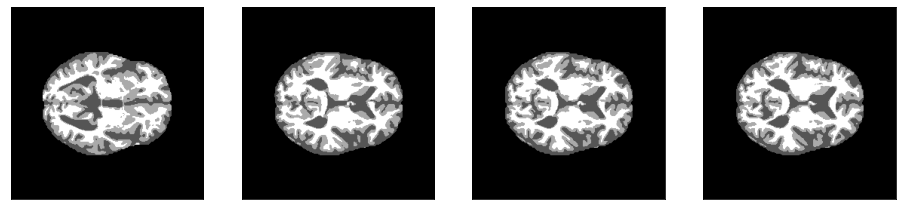

In [ ]:
# display five sample images in test set
n = 5
plt.figure(figsize=(20, 20))
for i in range(1, n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(y_test[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
hn = "he_normal"
def conv_block(tensor, n_filters, size=3, padding='same', initializer=hn, batch_norm=True):
    """create convolutional block for contraction path"""
    x = Conv2D(filters=n_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = Activation(LeakyReLU(alpha=0.1))(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Conv2D(filters=n_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = Activation(LeakyReLU(alpha=0.1))(x)
    if batch_norm:
        x = BatchNormalization()(x)
    return x

In [ ]:
def deconv_block(tensor, residual, n_filters, size=3, padding='same', strides=(2, 2), initializer=hn):
    """create blocks in the expansion path"""
    y = Conv2DTranspose(n_filters, kernel_size=(size, size), padding=padding,
                        strides=strides, kernel_initializer=initializer )(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, n_filters)
    return y

In [ ]:
def build_unet(img_height, img_width, n_filters=16, n_classes=4, drop_out=0.0, batch_norm=True):
    """create UNet model"""
    # input layer
    input_layer = Input(shape=(img_height, img_width, 1), name='image_input')

    # contraction path
    conv1 = conv_block(input_layer, n_filters=n_filters*1)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(conv1_out, n_filters=n_filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(conv2_out, n_filters=n_filters*4)
    conv3_max = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3_out = Dropout(drop_out*1)(conv3_max)

    conv4 = conv_block(conv3_out, n_filters=n_filters*8)
    conv4_max = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(drop_out*2)(conv4_max)

    conv5 = conv_block(conv4_out, n_filters=n_filters*16)

    # expansion path
    deconv6 = deconv_block(conv5, residual=conv4, n_filters=n_filters*8)
    deconv6 = Dropout(drop_out*2)(deconv6)

    deconv7 = deconv_block(deconv6, residual=conv3, n_filters=n_filters*4)
    deconv7 = Dropout(drop_out*1)(deconv7)

    deconv8 = deconv_block(deconv7, residual=conv2, n_filters=n_filters*2)
    deconv8 = deconv_block(deconv8, residual=conv1, n_filters=n_filters*1)

    # output layer
    output_layer = Conv2D(filters=n_classes, kernel_size=(1, 1))(deconv8)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 320         image_input[0][0]                
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 256, 256, 32) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        activation_20[0][0]              
_______________________________________________________________________________________________

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=0.):
    """calculate dice similarity coefficient (DSC)"""
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    return (2 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)

In [ ]:
def dice_coefficient_loss(y_true, y_pred):
    """calculate loss based on DSC"""
    return 1. - dice_coefficient(y_true, y_pred)

In [ ]:
model = build_unet(IMG_HEIGHT, IMG_WIDTH, n_filters=32, drop_out=0.05, batch_norm=True)
model.compile(optimizer=Adam(), loss="categorical_crossentropy",
              metrics=["accuracy", dice_coefficient])

In [ ]:
# set threshold to decrease lr, early stopping and save best model
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
# store model fitting stats
hist = model.fit(X_train, y_train_cat, batch_size=16, epochs=15, callbacks=callbacks,\
                 validation_data=(X_val, y_val_cat))

Train on 9664 samples, validate on 1120 samples
Epoch 1/15
9664/9664 [==============================] - 196s 20ms/step - loss: 0.3678 - accuracy: 0.9732 - dice_coefficient: 0.7124 - val_loss: 0.2746 - val_accuracy: 0.9536 - val_dice_coefficient: 0.7972

Epoch 00001: val_loss improved from inf to 0.27459, saving model to model-tgs-unet.h5
Epoch 2/15
9664/9664 [==============================] - 182s 19ms/step - loss: 0.1419 - accuracy: 0.9865 - dice_coefficient: 0.8779 - val_loss: 0.1095 - val_accuracy: 0.9817 - val_dice_coefficient: 0.9146

Epoch 00002: val_loss improved from 0.27459 to 0.10954, saving model to model-tgs-unet.h5
Epoch 3/15
9664/9664 [==============================] - 201s 21ms/step - loss: 0.0811 - accuracy: 0.9883 - dice_coefficient: 0.9318 - val_loss: 0.0657 - val_accuracy: 0.9881 - val_dice_coefficient: 0.9473

Epoch 00003: val_loss improved from 0.10954 to 0.06569, saving model to model-tgs-unet.h5
Epoch 4/15
9664/9664 [==============================] - 182s 19ms/st

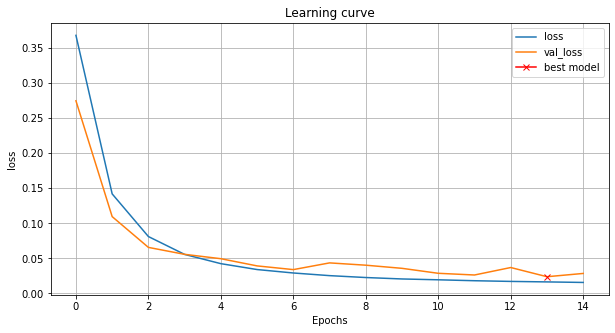

In [ ]:
# plot of training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.grid(True)
plt.legend();

In [ ]:
# load the best model
model.load_weights('model-tgs-unet.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best loss)
model.evaluate(X_val, y_val_cat, verbose=1)

1120/1120 [==============================] - 10s 9ms/step


[0.023903918585606983, 0.9910714030265808, 0.9882261157035828]

In [ ]:
# Predict on  test dataset
pred_test = model.predict(X_test, verbose=1)

544/544 [==============================] - 8s 14ms/step


In [ ]:
y_test_cat.dtype

dtype('float32')

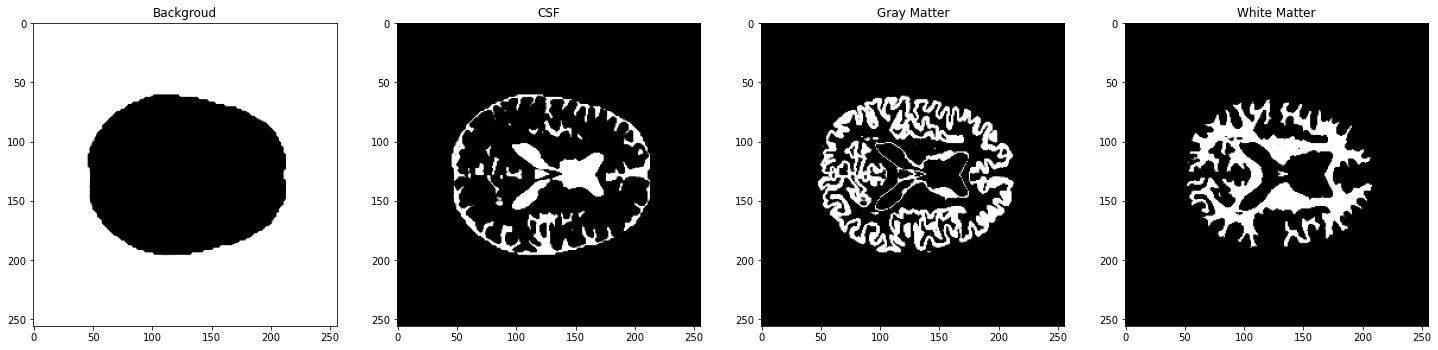

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(25, 15))
lab_list = ["Backgroud", "CSF", "Gray Matter", "White Matter"]
# print individual classes (components) of an image
for i in range(4):
    ax[i].imshow(pred_test[362][:,:,i])
    ax[i].set_title(lab_list[i])
plt.gray()

In [ ]:
pred_test_ind = np.argmax(pred_test, axis=3)

In [ ]:
pred_test_class = pred_test_ind.reshape(544, 256, 256, 1)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    """return mean overall DSC"""
    intersect = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersect + smooth)/(union + smooth), axis=0)
    return dice

In [ ]:
dice = dice_coef(y_test_cat, pred_test)
print("Dice Coefficent: {}%".format(round(dice.numpy() *100, 2)))

Dice Coefficent: 98.8%


In [ ]:
def plot_sample(X, y_actual, y_pred, ix=None):
    """print predicted image with input and ground truth"""
    if ix is None:
        ix = random.randint(0, len(X))
    else:
        ix = ix

    fig, ax = plt.subplots(1, 3, figsize=(25, 15))

    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(X[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input Image')

    ax[1].imshow(y_actual[ix, :,:,0], cmap='gray')
    ax[1].contour(y_actual[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Actual Output Image')

    ax[2].imshow(y_pred[ix, ..., 0], cmap='gray')
    ax[2].contour(y_pred[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Output Image')
    print(ix)

# Comparing predicted output image with actual output

30


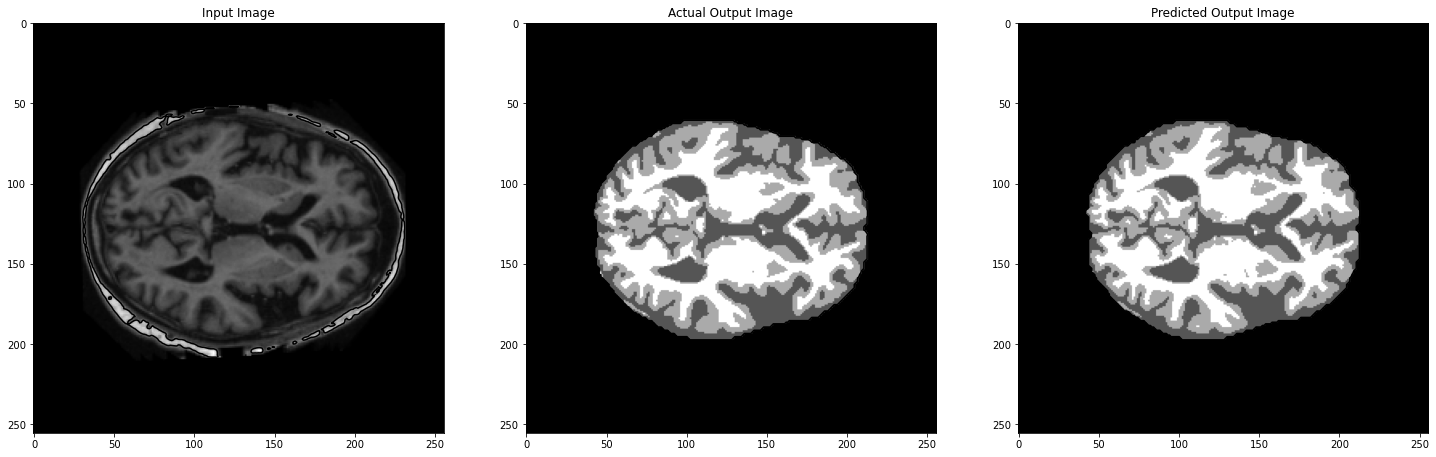

In [ ]:
# visualize how training data looks like
plot_sample(X_test, y_test, pred_test_class)